renormalization ended at step: 3149

renormalization took: 36.882 seconds

delta at was initially: -0.3587124353484791

ane at step 3149 was : -0.2591773205306921

analysis took: 9.96146 seconds



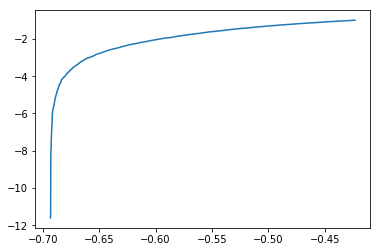

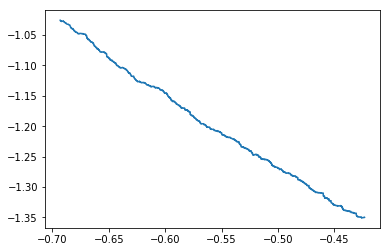

In [40]:
import numpy as np
import matplotlib.pyplot as plt
plt.tight_layout()
import time as t

class site:
    def __init__(self, position, properties):
        self.index = position
        for name,value in properties.items():
            setattr(self, name, value)

class FFexact:
    def __init__(self, inL):
        self.L = inL
        self.h0 = 1
        
    def randBuild(self, inh0):
        self.h0 = inh0
        tbuild = []
        for i in range(self.L-1):
            tbuild.append(np.random.uniform(0,self.h0))
            tbuild.append(np.random.uniform(0,1))
        tbuild.append(np.random.uniform(0,self.h0))
        tbuild = np.array(tbuild)
        self.T = np.zeros((2*self.L,2*self.L)) + np.diag(tbuild,1) + np.diag(tbuild,-1)
        temp = np.linalg.eigh(self.T)
        self.spectrum = temp[0]
        self.eigen = temp[1]
        
    def inputBuild(self, hlist, jlist):
        tbuild = []
        for i in range(self.L-1):
            tbuild.append(hlist[i])
            tbuild.append(jlist[i])
        tbuild.append(hlist[-1])
        tbuild = np.array(tbuild)
        self.T = np.zeros((2*self.L,2*self.L)) + np.diag(tbuild,1) + np.diag(tbuild,-1)
        temp = np.linalg.eigh(self.T)
        self.spectrum = temp[0]
        self.eigen = temp[1]

class Ising:
    def __init__(self, inL, inh0):
        self.L = inL
        self.h0 = inh0
        self.rstep = 0
        self.system = []
        self.Omegalist = []
        self.hlist = [[0]]
        self.jlist = [[0]]
        self.lslist = [[0]]
        self.lblist = [[0]]
        self.mlist = [[0]]
        for i in range(1,self.L):
            self.system.append(site(i, {'Jright':np.random.uniform(0,1), 'h':np.random.uniform(0,self.h0), 'ls':.5, 'lb':.5, 'm':.5}))
        self.system.append(site(self.L-1, {'Jright':0, 'h':np.random.uniform(0,self.h0), 'ls':.5, 'lb':.5, 'm':.5}))
        
        self.hlist[0][0] = self.system[0].h
        self.jlist[0][0] = self.system[0].Jright
        self.lslist[0][0] = self.system[0].ls
        self.lblist[0][0] = self.system[0].lb
        self.mlist[0][0] = self.system[0].m
        for i in range(1,self.L-1):
            self.hlist[0].append(self.system[i].h)
            self.jlist[0].append(self.system[i].Jright)
            self.lslist[0].append(self.system[i].ls)
            self.lblist[0].append(self.system[i].lb)
            self.mlist[0].append(self.system[i].m)
        self.hlist[0].append(self.system[self.L-1].h)
        self.lslist[0].append(self.system[self.L-1].ls)
        self.mlist[0].append(self.system[self.L-1].m)
        
        #finding OmegaI
        OmegaI = 0
        for i in range(self.L):
            if OmegaI<self.system[i].Jright:
                OmegaI = self.system[i].Jright
            if OmegaI<self.system[i].h:
                OmegaI = self.system[i].h
        self.Omegalist.append(OmegaI)
    
    def renormalize(self):
        L0 = self.L
        while(self.L > 1):
            self.renormStep()
            if np.absolute(self.gamma() >= .367):#self.delta())**(-1) <
                print("renormalization ended at step: " + str(self.rstep) + "\n")
                return
        print("failed to reach correct breakpoint")
        return
    
    def renormStep(self):
        bond = None
        Omega = 0
        OmegaPos = None
        
        #finding the max energy scale position
        for i in range(self.L):
            if Omega<self.system[i].Jright:
                Omega = self.system[i].Jright
                OmegaPos = i
                bond = True
            if Omega<self.system[i].h:
                Omega = self.system[i].h
                OmegaPos = i
                bond = False
        
        #decimating
        if bond:
            self.system[OmegaPos].h = self.system[OmegaPos+1].h * self.system[OmegaPos].h / Omega #hright*hleft/Omega
            self.system[OmegaPos].ls = self.system[OmegaPos].ls + self.system[OmegaPos+1].ls + self.system[OmegaPos].lb
            self.system[OmegaPos].lb = self.system[OmegaPos+1].lb
            self.system[OmegaPos].m = self.system[OmegaPos].m + self.system[OmegaPos+1].m
            self.system[OmegaPos].Jright = self.system[OmegaPos+1].Jright
            del self.system[OmegaPos+1]
        elif OmegaPos<(self.L-1) and OmegaPos != 0:
            self.system[OmegaPos-1].Jright = self.system[OmegaPos-1].Jright*self.system[OmegaPos].Jright/Omega #jleft*jright/Omega
            self.system[OmegaPos-1].lb = self.system[OmegaPos-1].lb + self.system[OmegaPos].ls + self.system[OmegaPos].lb
            del self.system[OmegaPos]
        elif OmegaPos == 0:
            del self.system[OmegaPos]
        else:
            self.system[OmegaPos-1].Jright = 0
            del self.system[OmegaPos]
        
        #book keeping
        self.L -= 1
        self.rstep += 1
        
        #adding new distribution info
        self.hlist.append([0])
        self.hlist[self.rstep][0] = self.system[0].h
        self.jlist.append([0])
        self.jlist[self.rstep][0] = self.system[0].Jright
        self.lslist.append([0])
        self.lslist[self.rstep][0] = self.system[0].ls
        self.lblist.append([0])
        self.lblist[self.rstep][0] = self.system[0].lb
        self.mlist.append([0])
        self.mlist[self.rstep][0] = self.system[0].m
        for i in range(1,self.L-1):
            self.hlist[self.rstep].append(self.system[i].h)
            self.jlist[self.rstep].append(self.system[i].Jright)
            self.lslist[self.rstep].append(self.system[i].ls)
            self.lblist[self.rstep].append(self.system[i].lb)
            self.mlist[self.rstep].append(self.system[i].m)
        self.hlist[self.rstep].append(self.system[self.L-1].h)
        self.lslist[self.rstep].append(self.system[self.L-1].ls)
        self.mlist[self.rstep].append(self.system[self.L-1].m)
        
        #finding new energy scale
        Omega = 0
        for i in range(self.L):
            if Omega<self.system[i].Jright:
                Omega = self.system[i].Jright
            if Omega<self.system[i].h:
                Omega = self.system[i].h
        self.Omegalist.append(Omega)
        
    #Analytic Output
    def printCouplings(self):
        for i in range(self.L-1):
              print('h' + str(i) + ' = ' + str(self.system[i].h) + '\nJ' + str(i) + ',' + str(i+1) + ' = ' + str(self.system[i].Jright))
        print('h' + str(self.L-1) + ' = ' + str(self.system[self.L-1].h))
        print()
    
    def printTracked(self, step = None):
        if step == None:
            step = self.rstep
        hlistlog = np.log(self.hlist[step])
        jlistlog = np.log(self.jlist[step])
        print('log average h is: ' + str(np.mean(hlistlog)))
        print('log h variance is: ' + str(np.var(hlistlog)) + '\n')
        print('log average J is: ' + str(np.mean(jlistlog)))
        print('log J variance is: ' + str(np.var(jlistlog)) + '\n')
        print('average spin cluster size is: ' + str(np.mean(self.lslist[step])) + '\n')
        print('average bond length is: ' + str(np.mean(self.lblist[step])) + '\n')
        print('average magnetic moment is: ' + str(np.mean(self.mlist[step]))+ '\n')
        print('energy scale is: ' + str(self.Omegalist[step])+ '\n')
    
    def delta(self, step = None):
        if step == None:
            step = self.rstep
        return (np.mean(np.log(self.hlist[step])) - np.mean(np.log(self.jlist[step])))/(np.var(np.log(self.hlist[step])) + np.var(np.log(self.jlist[step])))
    
    def gamma(self, step = None):
        if step == None:
            step = self.rstep
        return np.log(self.Omegalist[0]/self.Omegalist[step])
    
    def deltaTest(self, verbose = False, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        deltas = []
        for i in range(startStep, stopStep+1):
            if verbose:
                print('delta at level ' + str(i) + ' would be: ' + str(self.delta(i)) + '\n')
            deltas.append(self.delta(i))
        print('delta, over levels ' + str(startStep) + '-' + str(stopStep) + ', has variance: ' + str(np.var(deltas)) + '\n')
    
    def printDelta(self, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        print('delta at was initially: ' + str(self.delta(0)) + '\n')
        print('ane at step ' + str(stopStep) + ' was : ' + str(self.delta(stopStep)) + '\n')
    
    def gammaGraph(self, stopStep = None):
        gammas = []
        if stopStep == None:
            stopStep = self.rstep
        for i in range(1,stopStep):
            gammas.append(np.log(self.gamma(i)))
        out, sub = plt.subplots(1)
        sub.plot(gammas)
    
    def lngammaGraph(self, stopStep = None):
        lngammas = []
        if stopStep == None:
            stopStep = self.rstep
        for i in range(1,stopStep):
            lngammas.append(np.log(self.gamma(i)))
        out, sub = plt.subplots(1)
        sub.plot(lngammas)
    
    def typicalLengthTest(self, verbose = False, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        tlengthb = 0
        lv = 2/(np.var(np.log(self.hlist[0])) + np.var(np.log(self.jlist[0])))
        crossRenorm = 0
        for i in range(startStep, stopStep+1):
            tlengthb = np.exp(np.mean(np.log(self.lblist[i])))
            tlengthh = np.exp(np.mean(np.log(self.lslist[i])))
            if verbose:
                print('Typical bond length at level ' + str(i) + ' is: ' + str(tlengthb) + '\n')
                print('Typical cluster size at level ' + str(i) + ' is: ' + str(tlengthh) + '\n')
            if not crossRenorm:
                if tlengthb > lv:
                    crossRenorm = i
        print('The crossover where renorm has freed itself from initial conditions is: ' + str(crossRenorm) + '\n')
    
    def typicalLengthScalingGraph(self, startStep = 0, stopStep = None):
        printlist = []
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep+1):
            printlist.append(np.exp(np.average(np.log(self.lblist[i])))/((self.gamma(i))**(2)))
        out, sub = plt.subplots(1)
        sub.plot(printlist)
    
    def energyLengthScaling(self, startStep = 0, stopStep = None):
        #seems to not actually be correct
        if stopStep == None:
            stopStep = self.rstep
        VI = np.var(np.log(self.hlist[0])) + np.var(np.log(self.jlist[0]))
        for i in range(startStep, stopStep+1):
            print('log averaged h scales at renorm level ' + str(i) + ' with coefficient: ' + str(-np.mean(np.log(self.hlist[i]))/np.sqrt(VI * np.exp(np.mean(np.log(self.lslist[i]))))) + '\n')
            print('log averaged J scales at renorm level ' + str(i) + ' with coefficient: ' + str(-np.mean(np.log(self.jlist[i]))/np.sqrt(VI * np.exp(np.mean(np.log(self.lblist[i]))))) + '\n')
    
    def typicalEnergyLengthGraph(self, startStep = 0, stopStep = None):
        printlist = []
        lv = 2/(np.var(np.log(self.hlist[0])) + np.var(np.log(self.jlist[0])))
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep+1):
            printlist.append(((np.exp(np.mean(np.log(self.lblist[i]/lv))))**.5)/(self.gamma(i)))
        out, sub = plt.subplots(1)
        sub.plot(printlist)
    
    def momentPerLtest(self, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep, stopStep+1):
            print('Magnetization scaling coefficient: ' + str(np.average(np.divide(np.exp(np.mean(np.log(self.mlist[i]))),np.exp(np.mean(np.log(self.lslist[i])))))/(np.absolute(self.delta(i))**(3/2-np.sqrt(5)/2))) + '\n')
    
    def momentPerLdeltaGraph(self, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        printlist = []
        for i in range(startStep, stopStep+1):
            printlist.append(np.average(np.divide(np.exp(np.mean(np.log(self.mlist[i]))),np.exp(np.mean(np.log(self.lslist[i])))))/(np.absolute(self.delta(i))**(-3/2+np.sqrt(5)/2)))
        out, sub = plt.subplots(1)
        sub.plot(printlist)
    
    def momentPerLgammaGraph(self, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        printlist = []
        for i in range(startStep+1, stopStep+1):
            printlist.append(np.average(np.divide(np.exp(np.mean(np.log(self.mlist[i]))),np.exp(np.mean(np.log(self.lslist[i])))))/((self.gamma(i))**(3/2-np.sqrt(5)/2)))
        out, sub = plt.subplots(1)
        sub.plot(printlist)
    
    def typicalMomentTest(self, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep+1):
            print('Typical magnetic moment scaling coefficient at renorm ' + str(i) + ' is: ' + str(np.exp(np.average(np.log(self.mlist[i])))/((self.gamma(i))**(3/2-np.sqrt(5)/2))) + '\n')
    
    def typicalMomentGammaGraph(self, startStep = 0, stopStep = None):
        printlist0 = []
        printlist1 = []
        printlist2 = []
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep+1):
            printlist1.append(np.exp(np.average(np.log(self.mlist[i]))))
            printlist2.append(self.gamma(i))
            printlist0.append(np.exp(np.average(np.log(self.mlist[i])))/((self.gamma(i))**(1/2+np.sqrt(5)/2)))
        out, sub = plt.subplots(1)
        sub.plot(np.log(printlist1),np.log(printlist2))
    
    def typicalMomentDeltaGraph(self, startStep = 0, stopStep = None):
        printlist0 = []
        printlist1 = []
        printlist2 = []
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep+1):
            printlist1.append(np.exp(np.average(np.log(self.mlist[i]))))
            printlist2.append(np.absolute(self.delta(i)))
            printlist0.append(np.exp(np.average(np.log(self.mlist[i])))/((np.absolute(self.delta(i)))**(-1/2-np.sqrt(5)/2)))
        out, sub = plt.subplots(1)
        sub.plot(np.log(printlist1),np.log(printlist2))
    
    def typical2MomentGraph(self, startStep = 0, stopStep = None):
        #WARNING this is the incorrect definition of typical
        printlist = []
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep+1):
            printlist.append(np.average(np.log(self.mlist[i]))/((self.gamma(i))**(1/2+np.sqrt(5)/2)))
        out, sub = plt.subplots(1)
        sub.plot(printlist)
    
    def distGraph(self, startStep = 0, stopStep = None, gap = 1, h = True, J = True, lb = False, ls = False, m = False):
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep, stopStep, gap):
            if h:
                outh, subh = plt.subplots(1)
                subh.hist(np.log(self.hlist[i]),30)
            if J:
                outj, subj = plt.subplots(1)
                subj.hist(np.log(self.jlist[i]),30)
            if lb:
                outlb, sublb = plt.subplots(1)
                sublb.hist(self.lblist[i],10)
            if ls:
                outls, subls = plt.subplots(1)
                subls.hist(self.lslist[i],10)
            if m:
                outm, subm = plt.subplots(1)
                subm.hist(self.mlist[i],20)
        
            
            
        
        
        
    
L0 = 10000
h0 = .5

tester = Ising(L0,h0)

#exacty = FFexact(L0)
#exacty.randBuild(h0)
#print(exacty.spectrum)
#out, sub = plt.subplots(1)
#sub.plot(exacty.spectrum)

#tester.printCouplings()
#tester.printDistributions()
temp = t.clock()
tester.renormalize()
#for i in range(L0-10):
#    tester.renormStep()
print('renormalization took: ' + str(round(t.clock()-temp,3)) + ' seconds\n')
temp = t.clock()
tester.printDelta()
#tester.printCouplings()
#tester.printTracked()
#tester.lngammaGraph()
#tester.energyLengthScaling()
#tester.deltaTest(True)
#tester.momentPerLtest()
#tester.momentPerLdeltaGraph(startStep = 600)
#tester.momentPerLgammaGraph(startStep = 600)
#tester.distGraph(gap = 70,h = True, J = True, m = True)
tester.typicalMomentGammaGraph()
tester.typicalMomentDeltaGraph()
#tester.typicalLengthScalingGraph(startStep = 100)
#tester.typicalLengthTest()
#tester.typicalEnergyLengthGraph(startStep = 100)
print('analysis took: ' + str(round(t.clock()-temp,5)) + ' seconds\n')

In [33]:
tester.gamma()

0.36721188011640155

In [35]:
(tester.delta())**-1

-6.928387879936712